In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import xarray as xr

In [2]:
from osu_util import read_osu_log, read_osu_log_multi, plot_osu

In [3]:
ls osu_log/bcast/

N16n576/  N1n36/    N2n72/    N32n1152/ N4n144/   N8n288/


In [4]:
ls osu_log/bcast/N2n72/run3/

intelmpi-efa/ intelmpi-tcp/ mpich3/       openmpi3/     openmpi4/


In [5]:
ls osu_log/bcast/N2n72/run3/openmpi4

bcast_algo4.log    bcast_algo7.log    bcast_default.log


In [6]:
ls osu_log/bcast/N2n72/run3/intelmpi-efa

bcast_algo10.log   bcast_algo8.log    bcast_default.log


In [7]:
def read_bcast_scaling(suffix, prefix='./osu_log/bcast/'):
    N_list = [1, 2, 4, 8, 16, 32]

    file_list = [prefix + 'N{0}n{1}'.format(N, N*36) + suffix for N in N_list]
    # print(file_list)
    
    df = read_osu_log_multi(file_list, [N*36 for N in N_list])
    return df

In [8]:
df_impi_efa = read_bcast_scaling('/run3/intelmpi-efa/bcast_default.log')
df_impi_efa

,36,72,144,288,576,1152
size,,,,,,
1,0.91,30.14,20.70,20.33,20.93,43.12
2,0.91,30.35,20.43,20.32,21.30,43.77
4,1.77,30.67,20.82,20.50,21.23,44.54
8,1.77,30.64,20.49,20.58,20.98,43.84
16,1.82,30.62,20.80,20.66,20.76,43.62
32,1.58,30.55,20.47,20.44,20.99,43.46
64,1.81,30.31,20.82,20.58,20.88,44.81
128,1.53,30.31,20.51,20.52,20.62,44.74
256,1.94,30.52,21.16,20.87,20.74,45.01


In [9]:
mpi_cases = ['IntelMPI EFA', 'IntelMPI TCP', 'OpenMPI3', 'OpenMPI4', 'OpenMPI4 Knomial', 'MPICH3']

def read_all_mpi(RUNDIR='/run3/'):

    df_impi_efa = read_bcast_scaling(RUNDIR + 'intelmpi-efa/bcast_default.log')
    df_impi_tcp = read_bcast_scaling(RUNDIR + 'intelmpi-tcp/bcast_default.log')
    df_ompi3 = read_bcast_scaling(RUNDIR + 'openmpi3/bcast_default.log')
    df_ompi4 = read_bcast_scaling(RUNDIR + 'openmpi4/bcast_default.log')
    df_ompi4_algo7 = read_bcast_scaling(RUNDIR + 'openmpi4/bcast_algo7.log')
    df_mpich = read_bcast_scaling(RUNDIR + 'mpich3/bcast_default.log')
    
    return np.stack([df_impi_efa, df_impi_tcp, df_ompi3, df_ompi4, df_ompi4_algo7, df_mpich])

In [10]:
read_all_mpi().shape

(6, 21, 6)

In [11]:
def read_all_runs():
    all_runs = []
    for i in range(1, 6):
        all_runs.append(read_all_mpi(RUNDIR=f'/run{i}/'))
        
    all_runs = np.stack(all_runs) 
    print(all_runs.shape)  # (run, mpi, message size, cores)
        
    dr = xr.DataArray(
        all_runs, dims=('run', 'mpi', 'message', 'cores'), 
        coords={'mpi': mpi_cases,
                'message': df_impi_efa.index.values,
                'run': range(1, 6),
                'cores': [36, 72, 144, 288, 576, 1152]
               }
    )
    print(dr.sizes)
        
    return dr

In [12]:
dr = read_all_runs()
dr.coords

(5, 6, 21, 6)
Frozen(OrderedDict([('run', 5), ('mpi', 6), ('message', 21), ('cores', 6)]))


Coordinates:
  * mpi      (mpi) <U16 'IntelMPI EFA' 'IntelMPI TCP' ... 'MPICH3'
  * message  (message) int64 1 2 4 8 16 ... 65536 131072 262144 524288 1048576
  * run      (run) int64 1 2 3 4 5
  * cores    (cores) int64 36 72 144 288 576 1152

# Time vs message size

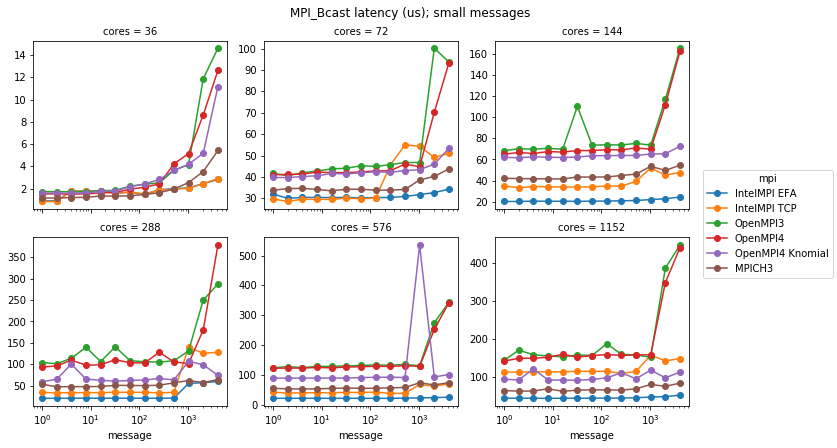

In [13]:
dr.isel(message=slice(0, 13)).mean('run').plot(
    hue='mpi', col='cores', col_wrap=3, sharey=False, marker='o')
plt.xscale('log')
plt.suptitle('MPI_Bcast latency (us); small messages', y=1.02)
plt.savefig('bcast_small_facet.png', dpi=144, bbox_inches='tight')

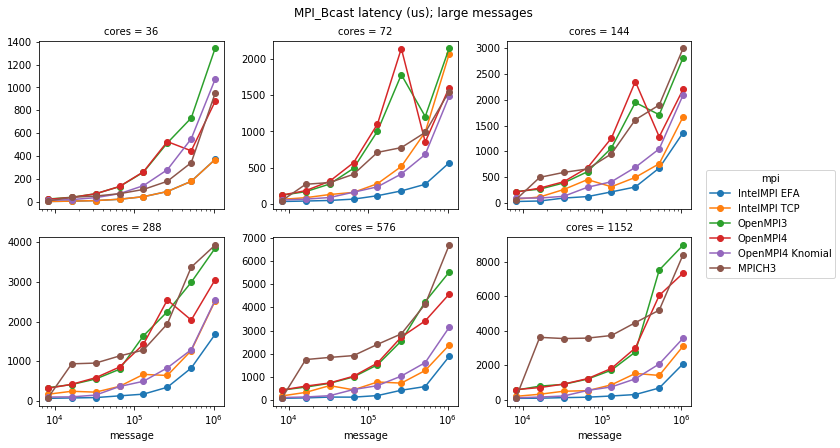

In [14]:
dr.isel(message=slice(13, None)).mean('run').plot(
    hue='mpi', col='cores', col_wrap=3, sharey=False, marker='o')
plt.xscale('log')
plt.suptitle('MPI_Bcast latency (us); large messages', y=1.02)
plt.savefig('bcast_large_facet.png', dpi=144, bbox_inches='tight')

# Time vs core

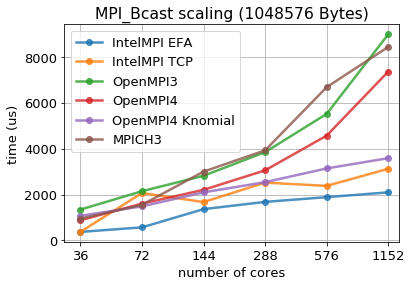

In [15]:
plt.rcParams['font.size'] = 13

from matplotlib.ticker import ScalarFormatter

fig, ax = plt.subplots(1, 1, figsize=[6, 4])

# message = 65536
message = 1048576

dr_sub = dr.sel(message=message)
df_mean = dr_sub.mean('run').to_pandas().T

df_mean.plot(ax=ax, marker='o', linewidth=2.5, alpha=0.8, logx=True, grid=True)
    
ax.set_ylabel('time (us)')
ax.set_xlabel('number of cores')

ax.xaxis.set_major_formatter(ScalarFormatter())
ax.minorticks_off()

ax.set_xticks(df_mean.index.values)
ax.set_xlim(30, 1300)

ax.legend()

ax.set_title('MPI_Bcast scaling ({} Bytes)'.format(message))
fig.savefig(f'bcast_scaling_{message}.png', dpi=144, bbox_inches='tight')